In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!sudo yum install xvfb python-opengl 
#!pip install gym pyvirtualdisplay

#!sudo yum uninstall xvfb
#!sudo yum -y install xorg-x11-server-Xvfb

#!pip install gym
#!apt-get install python-opengl -y
#!apt install xvfb -y

#!pip install piglet
# conda install -c conda-forge ffmpeg

In [3]:
%matplotlib inline
%matplotlib notebook

import gym
from gym.wrappers import Monitor
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.RL.DQN import DQN
from src.RL.EpsilonGreedyStrategy import EpsilonGreedyStrategy
from src.RL.Experience import Experience
from src.RL.ReplayMemory import ReplayMemory
from src.RL.CartPoleEnvManager import CartPoleEnvManager
from src.RL.Agent import Agent
from src.RL.QValues import QValues
from src.RL import Utils


In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(300, 400))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '300x400x24', ':1111'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '300x400x24', ':1111'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [5]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [6]:
import glob
import io

import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


In [7]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [8]:
batch_size = 256
gamma = 0.999 # discount factor for Bellman equation
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000
max_steps_per_episode = 200

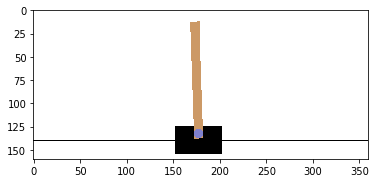

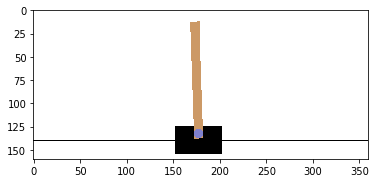

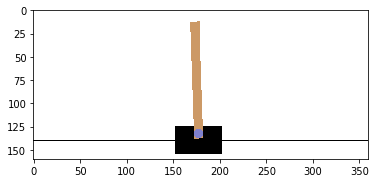

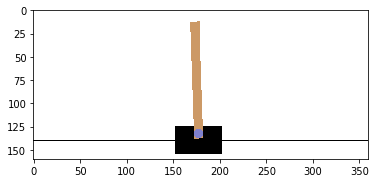

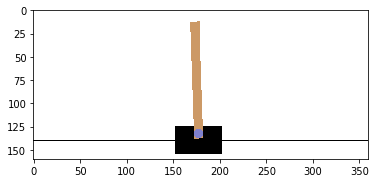

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#em = CartPoleEnvManager(device, timestep_limit = 1000, xvfb_mode=True)
em = CartPoleEnvManager(device, env_wrapper = wrap_env, timestep_limit = 100, xvfb_mode=True)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # no grad calculation needed for second net

optimizer = optim.Adam(params = policy_net.parameters(), lr=lr)



In [10]:
print(em.num_actions_available())

2


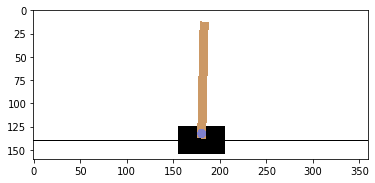

loop begin, timestep: 0  done: False


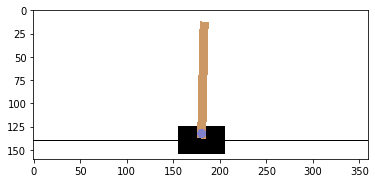

loop begin, timestep: 1  done: False


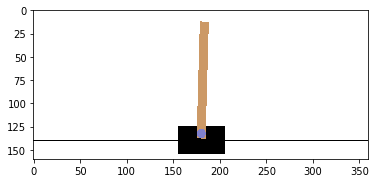

loop begin, timestep: 2  done: False


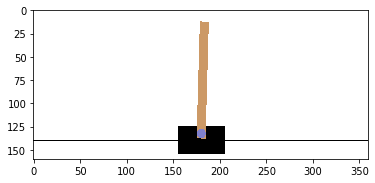

loop begin, timestep: 3  done: False


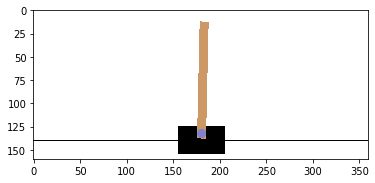

loop begin, timestep: 4  done: False


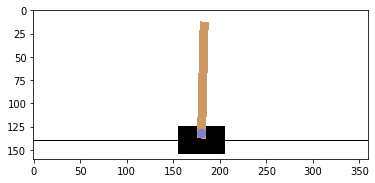

loop begin, timestep: 5  done: False


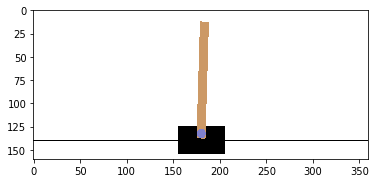

loop begin, timestep: 6  done: False


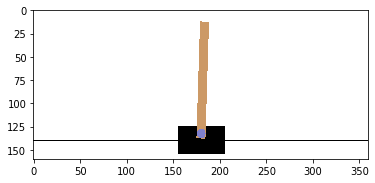

loop begin, timestep: 7  done: False


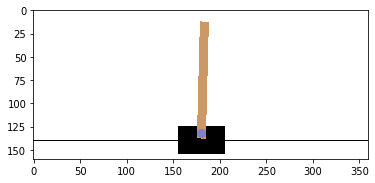

loop begin, timestep: 8  done: False


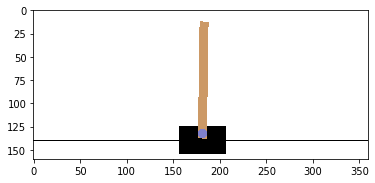

loop begin, timestep: 9  done: False


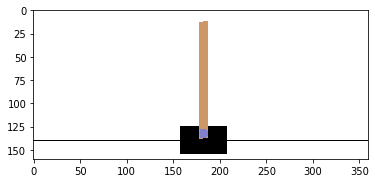

loop begin, timestep: 10  done: False


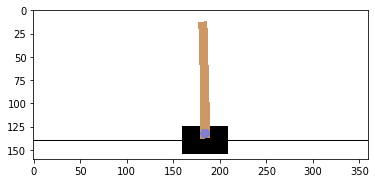

loop begin, timestep: 11  done: False


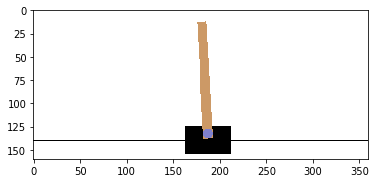

loop begin, timestep: 12  done: False


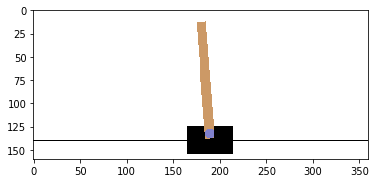

loop begin, timestep: 13  done: False


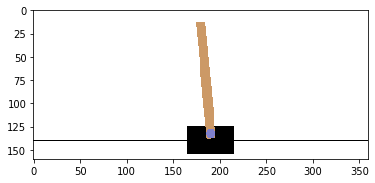

loop begin, timestep: 14  done: False


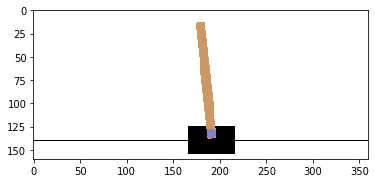

loop begin, timestep: 15  done: False


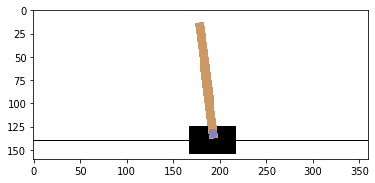

loop begin, timestep: 16  done: False


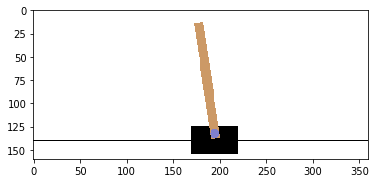

loop begin, timestep: 17  done: False


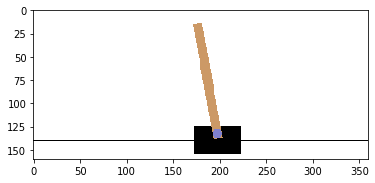

loop begin, timestep: 18  done: False


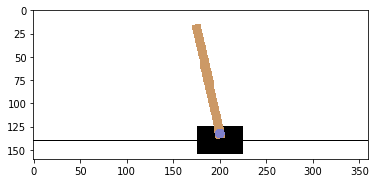

loop begin, timestep: 19  done: True


ResetNeeded: Trying to step environment which is currently done. While the monitor is active for CartPole-v0, you cannot step beyond the end of an episode. Call 'env.reset()' to start the next episode.

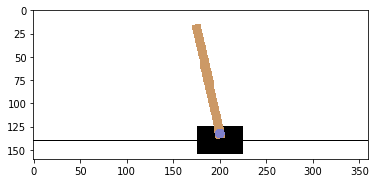

In [11]:
episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    #  For each episode, we first reset the environment, then get the initial state.
    # Now, we'll step into the nested for loop that will iterate over each time step within each episode. 
    #for timestep in count():
    for timestep in range(max_steps_per_episode):
        print('loop begin, timestep:', timestep, ' done:', em.done)
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = Utils.extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if em.done:
                print('Terminal state!', timestep, ' done:', em.done)
                episode_durations.append(timestep)
                Utils.plot(episode_durations, 100)
                break
            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
    #else:
    #    env.stats_recorder.save_complete()
    #    env.stats_recorder.done = True
env.monitor.close()            
em.close()            